1. Visusalize images from the dataset.
2. Visualize the behaviour of a random agent.

In [1]:
from medsegbench import Promise12MSBench
import torch.utils.data as data
import torch
import torchvision.transforms.v2 as transforms

data_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.RandomCrop(256)
])

crop_transform = transforms.RandomCrop(280)
val_dataset = Promise12MSBench(split="val", transform=data_transform, target_transform=data_transform, download=True)


147
torch.Size([1, 280, 280]) torch.Size([1, 280, 280])


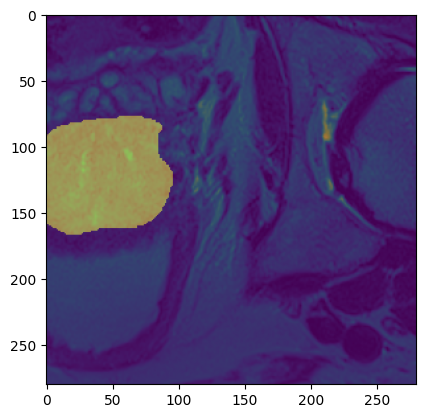

In [2]:
import matplotlib.pyplot as plt
print(len(val_dataset))
image, gt = crop_transform(val_dataset[0])
print(image.shape, gt.shape)
plt.imshow(image[0])
plt.imshow(gt[0], alpha=0.5)
plt.show()

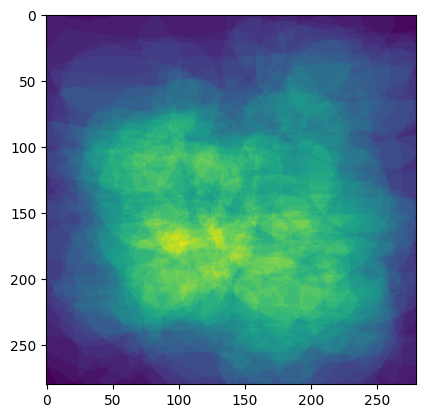

In [3]:
import numpy as np
gt_union = np.zeros_like(gt)[0]   
for (image, gt) in val_dataset:
    image, gt = crop_transform(image, gt)
    gt_union[gt[0] == 1] += 1
plt.imshow(gt_union)

plt.show()

In [4]:
from stable_baselines3 import PPO
import numpy as np
import sys
sys.path.append("/work/dlclarge2/ndirt-SegFM3D/learnedpatch") 
from src.patchselectionenv import GymPatchSelectionEnv, dice_score

image_list = [val_dataset[i][0] for i in range(len(val_dataset))]
mask_list = [val_dataset[i][1] for i in range(len(val_dataset))]
patch_size = (32, 32)
max_steps = 10

env = GymPatchSelectionEnv(image_list, mask_list, patch_size, max_steps)

# Load trained PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.load("/work/dlclarge2/ndirt-SegFM3D/learnedpatch/results/ppo_learnedpatch/rl_model_500000_steps.zip")

torch.Size([512, 512])
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/work/dlclarge2/ndirt-SegFM3D/learnedpatch/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/work/dlclarge2/ndirt-SegFM3D/learnedpatch/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


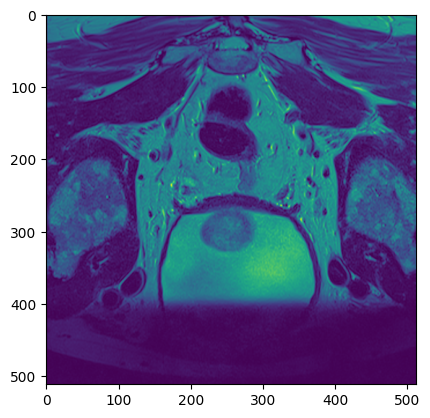

Reward: 3.982477125852313e-10


In [ ]:
obs = env.reset()
done = False
plt.imshow(obs[0].numpy())
plt.show()
while not done:
    
    action, _ = model.predict(obs)
    """
    r = np.random.randint(0, env.env.image.shape[0] - patch_size[0] + 1)
    c = np.random.randint(0, env.env.image.shape[1] - patch_size[1] + 1)
    action = (r, c)
    """
    obs, reward, done, info = env.step(action)
    plt.imshow(obs[2].numpy(), alpha=0.5)
print(f"Reward: {reward}")